# Connectome-based Predictive Modeling (CPM)
Predicting behavioral measures from whole-brain functional connectivity. We focus here on the reinforcement learning tasks, reward and punishment, from a set of n=85 subjects from the Bevel dataset. 

For the CPM analysis, we need:
- **a set of functional connectivity matrices**, at least one per subject, and,
- a list of behavioral measures for each subject.

Matrices are stored in a `.txt` file and the behvaioral is in `.csv`.   
<br>
<br>


In [1]:
print("[INFO] installing nilearn for session...")
!pip install nilearn

[INFO] installing nilearn for session...


In [0]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import os, glob
from nilearn.plotting import plot_connectome
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from IPython.core import display as ICD
pd.set_option('display.max_rows', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print("[INFO] mounting google drive directory...\n[INFO] if prompted follow the link and copy and paste the token.")
from google.colab import drive
drive.mount('/content/drive')

[INFO] mounting google drive directory...
[INFO] if prompted follow the link and copy and paste the token.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Helper Functions**

In [0]:
# make fc matrices
"""
  Takes timeseries matrices and makes functional connectivity matrices with nilearns ConnectivityMeasure object.
  We pass a condition, or named here the 'file_suffix', to identify our individual task files,
  and we pass the number of extracted regions.
  Outputs: makes subject FCMs, plots FCMs
  Returns: a function correlation dictionary as well as individual subject list

  ** Extensions: plotting, save individual FCMs...
"""
def makeFCM(cmap, timeseries=None, n_regions_extracted=28, file_suffix=condition, functionals=None):
  #print('[INFO] making functional connectivity matrices with nilearn ConnectivityMeasure object...')
  fc_corr_dict = {}
  subj_list=[]
  correlations = []
  # Initializing ConnectivityMeasure object with kind='correlation'
  connectome_measure = ConnectivityMeasure(kind='correlation')
  for subj_timeseries in sorted(timeseries_matrices):
    subj_id=subj_timeseries.split("/")[-1].split("_")[0]
    if subj_id not in fc_corr_dict:
      fc_corr_dict[subj_id] = {}
    if subj_id not in subj_list:
      subj_list.append(subj_id)
    if file_suffix in subj_timeseries:
      filename = "%s_%s.txt"%(subj_id, file_suffix)
      # we load the text file timeseries into an array 
      np_arr = np.loadtxt(subj_timeseries)
      # call fit_transform from ConnectivityMeasure object
      correlation = connectome_measure.fit_transform([np_arr])
      # saving each subject correlation to correlations
      fc_corr_dict[subj_id][file_suffix] = correlation
      correlations.append(correlation)
      
      # save text
      #np.savetxt('/content/'+filename, correlation.transpose(2,0,1).reshape(3,-1))

    # Mean of all correlations
  mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted, n_regions_extracted)



  ## plotting
  print('[INFO] Plot of the mean functional connectivity matrix: \n')
  title = 'Correlation between %d regions, condition %s'%(n_regions_extracted, condition)
  # First plot the matrix
  display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1, colorbar=True, title=title, cmap=cmap)
  plt.show()
  print("\n\n")
  # Then find the center of the regions and plot a connectome
  #regions_img = regions_extracted_img
  #coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

  #plotting.plot_connectome(mean_correlations, coords_connectome,
                          #edge_threshold='90%', title=title)
        
  return fc_corr_dict, subj_list;



  

In [0]:
def read_in_matrices(subj_list, fc_corr_dict, file_suffix=None, data_dir=data_dir, zscore=False):
    """
    Reads in a set of individual-subject connectivity matrices stored in data_dir,
    
    Returns a dataframe that is subjects x edges (by vectorizing the upper triangle of each FC matrix).
    
    Assumes:
    - each matrix is stored in a separate file beginning with the subject ID, and
    - matrices are symmetric (squareform); i.e., for a parcellation with 268 nodes, matrices should be 268 x 268
    """
    
    all_fc_data = {}
            
    for subj in subj_list:
        # try to find this subject's matrix
        try:
          if file_suffix:
              # make list files found
              matrix = fc_corr_dict[subj][file_suffix]
            #file = [f for f in matrices if subj in f and file_suffix in f]
        #else:
            #file = [f for f in matrices if subj in f]
        except:
          pass    
        # make sure there is one and only one file    
        #if len(file) ==0:
            #raise ValueError("No data found for subject {}".format(subj))
        #if len(file) >1:
            #raise ValueError("More than one matrix found for subject {}! Specify a suffix?".format(subj))
        
        # read it in and make sure it's symmetric and has reasonable dimensions
        tmp = matrix.transpose(2,0,1).reshape(28,-1)

        assert tmp.shape[0]==tmp.shape[1]>1, "Matrix seems to have incorrect dimensions: {}".format(tmp.shape)
        
        # take just the upper triangle and store it in a dictionary
        if ~zscore:
            all_fc_data[subj] = tmp[np.triu_indices_from(tmp, k=1)]
        if zscore:
            all_fc_data[subj] = sp.stats.zscore(tmp[np.triu_indices_from(tmp, k=1)])
        
    # Convert dictionary into dataframe
    all_fc_data = pd.DataFrame.from_dict(all_fc_data, orient='index')
    #print('[INFO] made functional connectivity matrix dataframe.')


    return all_fc_data

In [0]:
def mk_kfold_indices(subj_list, k):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)

In [0]:
def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

In [0]:
def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

In [0]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [0]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "[ERROR FOUND] Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [0]:
def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
      #print(tail, mask)
      X = test_vcts.loc[:, mask].sum(axis=1)
      X_glm[:, t] = X

      slope, intercept = model_dict[tail]
      behav_pred[tail] = slope*X + intercept
      t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

In [0]:
def cpm_wrapper(all_fc_data, all_behav_data,condition, behav,  k, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        #print("[INFO] doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        try:
          model_dict = build_model(train_vcts, mask_dict, train_behav)
          #print(model_dict.keys())
          #print("[INFO] model building complete.")
        except Exception as e:
          print("[ERROR FOUND] {} \n".format(e))
        try:
          behav_pred = apply_model(test_vcts, mask_dict, model_dict)
          #print("[INFO] glm applied, behavior predicted with test set.")
        except Exception as e:
          print("[ERROR FOUND] {} \n".format(e))
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    if not behav_obs_pred.empty: print('[INFO] CPM completed with %s folds.'%(k))
    return behav_obs_pred, all_masks

In [0]:
def plot_predictions(behav_obs_pred,color, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color=color)
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')

    #print(y.columns.values)
    r = sp.stats.pearsonr(x['BMI observed'],y['BMI predicted (glm)'])
    r_value = r[0]
    p_value = r[1]
    g.annotate('r = {0:.2f}'.format(r_value), xy = (0.7, 0.9), xycoords = 'axes fraction')
    
    return g

In [0]:
def plot_consistent_edges(all_masks, roi_coords, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    edge_frac_square = sp.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,title=tail, node_coords=roi_coords, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))


In [0]:
def cpmPipeline(cmap,condition, behav, matrices_path, cpm_kwargs, behavioral,cond_color,k):
  # first step compute timeseries matrix
  timeseries_matrices=glob.glob(os.path.join(matrices_path, "*.txt"))
  fc_corr_dict,subj_list=makeFCM(cmap, timeseries_matrices, file_suffix=condition, functionals=None)
  # make functional connectivity matrix of all subjects
  all_fc_data = read_in_matrices(behavioral.index.values.tolist(), fc_corr_dict,file_suffix=condition)
  # replace infinite values with nan
  all_fc_data.replace([np.inf, -np.inf], np.nan)
  # fill nan values with column average
  all_fc_data.fillna(all_fc_data.mean(axis=1), inplace=True)

  behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, behavioral, condition, behav,k, **cpm_kwargs)

  print("\n")
  ICD.display(behav_obs_pred.head())
  # plot scatter plot
  print('\nPlot of Observed vs. Predicted Behavior \n')
  g = plot_predictions(behav_obs_pred,cond_color)
  g.set_title(condition.upper())
  plt.show()

  print("\n\n\n")

  roi_coords=pd.read_csv('betaseries_rois.txt', sep='\t')
  roi_coords.set_index("Region", inplace=True)
  #ICD.display(roi_coords.head())
  plot_consistent_edges(all_masks, roi_coords, "pos", thresh = 0.8, color = 'deeppink')
  plot_consistent_edges(all_masks, roi_coords, "neg", thresh = 0.8, color = 'purple')


In [0]:
def main(condition, behav, cond_color,matrices_path,cmap, k):
  #setup input parameters 
  matrices_path='/content'
  cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

  #run pipeline
  cpmPipeline(cmap,condition, behav, matrices_path, cpm_kwargs, behavioral, cond_color,k)


## Behavioral Setup



**Load in the behavioral `.csv` file and modify for input**

For the behavioral file the ID column was modified, replacing "bevel" prefix with "sub-0", to match the FCM input. The ID column is then set to the index and renamed to "Subject". The ids not found in the subject list are dropped from behavioral, and NaN values are filled with 0.

In [525]:
# behavioral 
behavioral_file='/content/clean_bevel.csv'

behavioral=pd.read_csv(behavioral_file)
behavioral['ID'] = behavioral['ID'].str.replace('Bevel', 'sub-0')
behavioral['ID'] = behavioral['ID'].str.replace('bevel', 'sub-0')
behavioral.set_index('ID', inplace=True)
behavioral.index.name="Subject"
#remove subjects that were dropped
remove_ids = [x for x in behavioral.index.values if x not in subj_list]
behavioral.drop(remove_ids, inplace=True)
behavioral.fillna(0,inplace=True)
behavioral.head()

,intials,date,weight,height,BMI,BMI_cat,hba1c,bloodglucose,bitter,age,DOB,hispanic,race1,sex,mens_date,mens_length,sensitivity_reward,sensitivity_punish,test_result_group,preTTfullness,preTThunger,preTTthirst,hourssincelastmeal,sweetstim_level,sweetstim_pleasent,sweetstim_desire,sweetstim_intense,sweetstim_bitter,sweetstim_sweet,bitterstim_level,bitterstim_pleasent,bitterstim_desire,bitterstim_intense,bitterstim_bitter,bitterstim_sweet,sweet1pleasent,sweet1desire,sweet1intense,sweet1bitter,sweet1sweet,...,RT_cd,RT_ef,%_correct,%correct_run1,%correct_run2,%correct_run3,%correct_run4,%correct_ab_run1,%correct_ab_run2,%correct_ab_run3,%correct_ab_run4,trials_AB_run1,trials_AB_run2,trials_AB_run3,trials_AB_run4,%correct_cd_run1,%correct_cd_run2,%correct_cd_run3,%correct_cd_run4,trials_cd_run1,trials_cd_run2,trials_cd_run3,trials_cd_run4,%correct_ef_run1,%correct_ef_run2,%correct_ef_run3,%correct_ef_run4,trials_ef_run1,trials_ef_run2,trials_ef_run3,trials_ef_run4,taste_run1,taste_run2,taste_run3,taste_run4,notes,alpha_pos,alpha_neg,criteria_met,training_slope
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sub-001,JRS,3/19/18,77.6,178.0,24.5,HW,4.5,94,2,24,5/5/93,non-hispanic,caucasian,male,0,0,0.555556,0.833333,learner,-70,65,23,0.0,2,21,25,14,14,12,2,-39,-63,51,52,-17,3,4,-35,-19,-24,...,1.604,1.595,49.00%,52.20%,54.20%,34.60%,56.50%,63.60%,57.10%,25.00%,54.50%,11,7,12.0,11.0,44.40%,50.00%,42.90%,66.70%,9,10,7.0,6.0,33.30%,57.10%,42.90%,50.00%,3,7,7.0,6.0,23,24,26,23,good,0.350563,0.638784,0,neg_slope
sub-002,JRS,3/21/18,56.0,167.0,20.1,HW,4.6,94,2,19,10/22/98,non-hispanic,asian,female,3/9/18,4,0.590909,0.625000,learner,34,-24,68,5.0,4,48,38,15,-100,15,4,-34,-28,38,22,-35,24,15,11,-98,6,...,1.604,1.602,56.60%,50.00%,72.00%,57.70%,46.20%,33.30%,66.70%,45.50%,0.00%,6,6,11.0,4.0,57.10%,85.70%,40.00%,57.10%,7,7,5.0,7.0,55.60%,66.70%,80.00%,53.30%,9,12,10.0,15.0,22,25,26,26,good,0.352071,0.638182,0,neg_slope
sub-003,JRS,3/23/18,72.5,153.5,30.8,OB,4.8,85,2,23,4/6/94,non-hispanic,caucasian,female,2/28/18,28,0.583333,0.521739,learner,-49,35,47,5.0,2,4,20,-2,-65,14,4,-13,-16,21,55,13,-8,-8,14,12,17,...,1.586,1.583,46.60%,60.00%,50.00%,23.10%,53.80%,44.40%,57.10%,36.40%,41.70%,9,7,11.0,12.0,55.60%,46.20%,25.00%,66.70%,9,13,8.0,6.0,85.70%,50.00%,0.00%,62.50%,7,6,7.0,8.0,25,26,26,26,good,0.351216,0.639118,0,neg_slope
sub-004,"JRS, MAN",4/26/18,54.5,166.5,19.7,HW,5.0,80,1,24,6/27/93,non-hispanic,caucasian,female,3/15/18,Sporadic,0.600000,0.450000,reward_learner,-65,60,72,9.0,3,-15,-23,0,12,15,2,-11,-25,20,22,0,-40,-64,36,36,-34,...,1.593,1.590,56.40%,58.30%,57.70%,50.00%,60.00%,66.70%,62.50%,44.40%,53.80%,9,8,9.0,13.0,50.00%,36.40%,44.40%,75.00%,10,11,9.0,8.0,60.00%,85.70%,62.50%,50.00%,5,7,8.0,4.0,24,26,26,25,good,0.350969,0.638079,0,neg_slope
sub-005,J,3/28/18,50.5,160.5,19.6,HW,0.0,94,1,18,7/18/99,non-hispanic,asian,female,3/21/18,30,0.333333,0.416667,nonlearner,-100,74,47,7.0,4,56,55,50,-81,50,4,-70,-67,100,70,-100,-26,-39,23,30,-7,...,1.592,1.588,52.10%,56.00%,38.50%,56.00%,60.00%,70.00%,45.50%,83.30%,77.80%,10,11,6.0,9.0,36.40%,16.70%,66.70%,33.30%,11,6,6.0,3.0,75.00%,44.40%,38.50%,50.00%,4,9,13.0,8.0,25,26,25,20,good,0.352031,0.637929,0,pos_slope


### Choose the behavioral measure
It's a good idea to look at a histogram to make sure there is actually variability across subjects, and the distribution isn't too skewed.  
*Note that if your behavior is highly skewed (i.e., non-normally distributed), you should consider using Spearman (rank) correlation in the CPM feature selection step (you can do this by setting corr_type to spearman [default pearson] in the cpm_kwargs dictionary).*

View behavior measures we can choose from:


In [0]:
#print('\n'.join(behavioral.columns.values))

Looking at BMI:

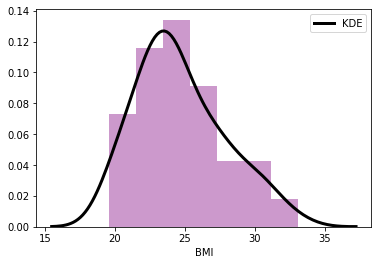

In [527]:
behav = 'BMI'
sns.distplot(behavioral[behav], color="purple",kde_kws={"color": "k", "lw": 3, "label": "KDE"})
plt.show()

In [528]:
behavioral.loc[:, behav].describe()

count    85.000000
mean     24.675294
std       3.153717
min      19.600000
25%      22.400000
50%      24.000000
75%      26.900000
max      33.100000
Name: BMI, dtype: float64

## Run CPM on RL Tasks 
Tasks available:
- reward
- punishment



### Punish


[INFO] Plot of the mean functional connectivity matrix: 



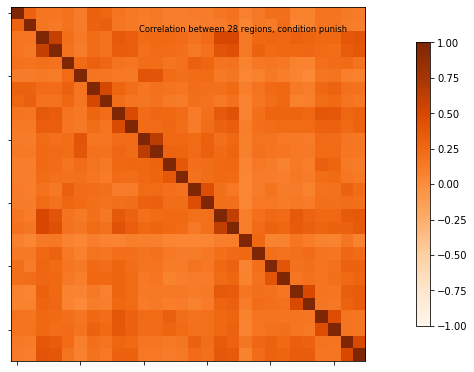




[INFO] CPM completed with 100 folds.




,BMI predicted (pos),BMI predicted (neg),BMI predicted (glm),BMI observed
sub-001,24.1936,24.8529,24.3728,24.5
sub-002,25.0752,22.8593,23.1775,20.1
sub-003,23.2253,25.2465,23.8577,30.8
sub-004,23.9218,24.9591,24.1364,19.7
sub-005,26.0053,25.0773,26.3287,19.6



Plot of Observed vs. Predicted Behavior 



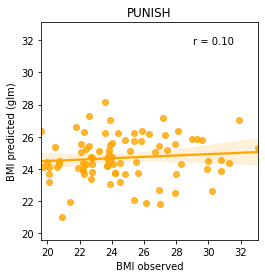





For the pos tail, 3 edges were selected in at least 80.0% of folds
For the neg tail, 8 edges were selected in at least 80.0% of folds


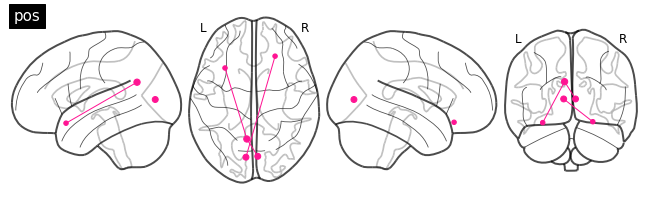

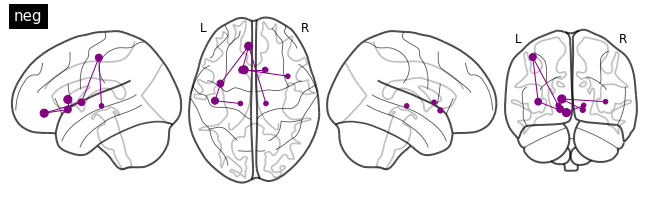

In [536]:
condition="punish"
matrices_path="/content"
behav="BMI"
cmap="Oranges"
k=100
cond_color='orange'
main(condition, behav,cond_color, matrices_path,cmap,k)

### Reward Task

[INFO] Plot of the mean functional connectivity matrix: 



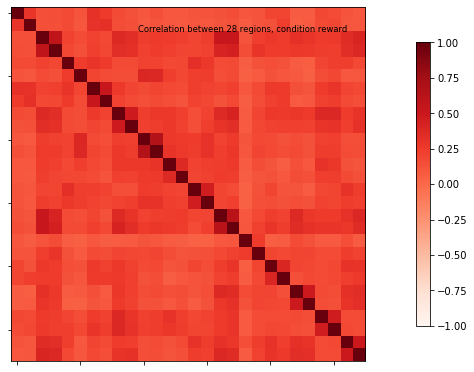




[INFO] CPM completed with 100 folds.




,BMI predicted (pos),BMI predicted (neg),BMI predicted (glm),BMI observed
sub-001,25.5391,24.4024,25.3002,24.5
sub-002,24.2872,23.7731,23.3026,20.1
sub-003,25.2684,24.6154,25.3452,30.8
sub-004,24.6911,25.1584,25.1556,19.7
sub-005,26.1608,24.816,26.3943,19.6



Plot of Observed vs. Predicted Behavior 



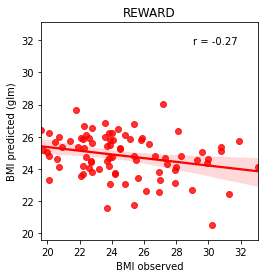





For the pos tail, 8 edges were selected in at least 80.0% of folds
For the neg tail, 3 edges were selected in at least 80.0% of folds


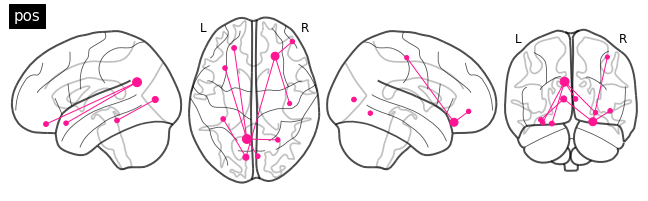

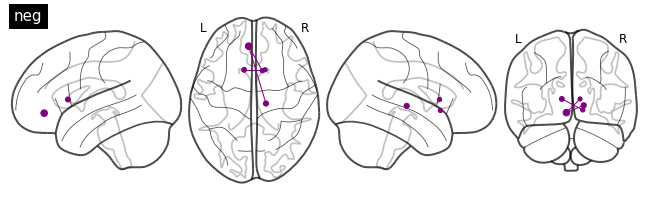

In [537]:
condition="reward"
matrices_path="/content"
behav="BMI"
k=100
cmap="Reds"
cond_color='red'
main(condition, behav,cond_color, matrices_path,cmap,k)

**Reference:**  
https://github.com/esfinn/cpm_tutorial/blob/master/cpm_tutorial.ipynb